## Experiments with _Water meters_!
In this notebook we will train ResNet101, DenseNet121 and VGG19 to predict numbers on water meter.

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('..')

import meters as ms
from meters.batch import MeterBatch
from meters.dataset import B,V,F, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet101, DenseNet121, VGG19


plt.style.use('seaborn-poster')
plt.style.use('ggplot')

Create fileindex witch allows us to loading only part of images instead all images.

`src` - the path to images in blosc format.

In [2]:
src = './../shows/data/images/'

fileindex = FilesIndex(path=src+'*.blosc', no_ext=True)

dset = Dataset(fileindex, batch_class=MeterBatch)
dset.cv_split()

Write pipeline to load and crop data and labels

In [4]:
load_ppl = (
    Pipeline()
    .load(src=src, fmt='blosc', components='images')
    .load(src='./../shows/data/new_data.csv',\
          fmt='csv',\
          components=['coordinates', 'labels'],\
          index_col='file_name')
    .crop_from_bbox()
    .split_labels()
    .split_to_digits(n_digits=8)
    .resize(shape=(64, 32))
)

In [5]:
# добавить к названиям всех файлов и лейблам буковку
# обновить ноутбук
# дописать аппенд в ноутбук

In [6]:
a = (load_ppl<< dset.train).next_batch(1)

With config create model parameters 

In [6]:
inputs_config = {
    'images': {'shape': (64, 32, 3)},
    'labels': {'classes': (10), 'transform': 'ohe', 'name': 'targets'}
}

config = {
    'inputs': inputs_config,
    'optimizer': 'Adam',
    'loss': 'ce',
    'input_block/inputs': 'images',
    'head/units': 10,
    'output': dict(ops=['labels', 'proba', 'accuracy'])
}

We will experements with models. For this create dict with:
* `key` - model
* `value` - model name

In [7]:
models = [DenseNet121, VGG19, ResNet101]
models_names = ['DenseNet121', 'VGG19', 'ResNet101']
models_dict = dict(zip(models_names, models))

In [9]:
def get_ppl(model, name):
    """"Create train and test pipeline using given `model` and `name`
    
    Parameters
    ----------
    model : Dataset model
        preloaded model from dataset
    
    name : str
        name of model
    
    Returns
    -------
    train_ppl : Dataset pipeline
        train pipeline

    test_ppl : Dataset pipeline
        test pipeline"""
    train_ppl = (
        (load_ppl << dset.train)
        .init_variable('model', model)
        .init_variable('loss', init_on_each_run=list)
        .init_model('dynamic',
                    V('model'),
                    name,
                    config=config)
        .train_model(name,
                     fetches='loss',
                     feed_dict={'images': B('images'),
                                'labels': B('labels')},
                     save_to=V('loss'), 
                     mode='a')
    )

    test_ppl = (
        (load_ppl << dset.test)
        .init_variable('proba', init_on_each_run=list)
        .init_variable('target', init_on_each_run=list)
        .init_variable('accuracy', init_on_each_run=list)
        .import_model(name, train_ppl)
        .predict_model(name,
                       fetches=['output_proba',
                                'targets',
                                'output_accuracy'],
                       feed_dict={'images': B('images'),
                                  'labels': B('labels')},
                       save_to=[V('proba'), 
                                V('target'), 
                                V('accuracy')], 
                       mode='a')
    )
    pred_ppl = (
    (load_ppl << dset.test)
    .init_variable('accuracy', init_on_each_run=list)
    .import_model(name, train_ppl)
    .predict_model(name,
                   fetches=['output_accuracy'],
                   feed_dict={'images': B('images'),
                              'labels': B('labels')},
                   save_to=[V('accuracy')], 
                   mode='a')
    )
    return train_ppl, test_ppl

train pipelines with different models and save it after training

In [10]:
global_acc = []
for name, model in models_dict.items():
    print(name)
    train_ppl, test_ppl = get_ppl(model, name)
    for i in tqn(range(900)):
        tr = train_ppl.next_batch(25, n_epochs=None, suffle=True, drop_last=True)
        te = test_ppl.next_batch(25, n_epochs=None, suffle=True, drop_last=True)
    plt.plot(test_ppl.get_variable('accuracy'), label=name+'accuracy')
    plt.legend(fontsize=14)
    plt.show()
    global_acc.append(test_ppl.get_variable('accuracy'))
    train_ppl.save_model(name, path=name)

DenseNet121


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ResourceExhaustedError: OOM when allocating tensor of shape [128] and type float
	 [[Node: DenseNet121/DenseNet121/body/block-3/conv-17/layer-0/batch_normalization/gamma/Adam/Initializer/zeros = Const[_class=["loc:@DenseNet121/body/block-3/conv-17/layer-0/batch_normalization/gamma"], dtype=DT_FLOAT, value=Tensor<type: float shape: [128] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'DenseNet121/DenseNet121/body/block-3/conv-17/layer-0/batch_normalization/gamma/Adam/Initializer/zeros', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/anton/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/anton/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/anton/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/anton/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/anton/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/anton/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/anton/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/anton/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/anton/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/anton/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/anton/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/anton/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/anton/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/anton/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-86b9648e4fa1>", line 6, in <module>
    tr = train_ppl.next_batch(25, n_epochs=None, suffle=True, drop_last=True)
  File "../meters/dataset/dataset/pipeline.py", line 1059, in next_batch
    batch_res = next(self._batch_generator)
  File "../meters/dataset/dataset/pipeline.py", line 1032, in gen_batch
    batch_res = self._exec(batch)
  File "../meters/dataset/dataset/pipeline.py", line 576, in _exec
    batch_res = self._exec_all_actions(batch)
  File "../meters/dataset/dataset/pipeline.py", line 554, in _exec_all_actions
    action_fn(batch, _action)
  File "../meters/dataset/dataset/pipeline.py", line 852, in _exec_train_model
    model = self.get_model_by_name(action['model_name'], batch=batch)
  File "../meters/dataset/dataset/pipeline.py", line 611, in get_model_by_name
    return self.models.get_model_by_name(name, batch=batch)
  File "../meters/dataset/dataset/model_dir.py", line 86, in get_model_by_name
    model = self.create_model(model_class, config)
  File "../meters/dataset/dataset/model_dir.py", line 92, in create_model
    model = model_class(config=config)
  File "../meters/dataset/dataset/models/tf/base.py", line 208, in __init__
    super().__init__(*args, **kwargs)
  File "../meters/dataset/dataset/models/base.py", line 28, in __init__
    self.build(*args, **kwargs)
  File "../meters/dataset/dataset/models/tf/base.py", line 250, in build
    train_step = optimizer.minimize(self.loss, global_step=self.global_step)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/adam.py", line 132, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/optimizer.py", line 766, in _zeros_slot
    named_slots[_var_key(var)] = slot_creator.create_zeros_slot(var, op_name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/slot_creator.py", line 174, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/slot_creator.py", line 146, in create_slot_with_initializer
    dtype)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/slot_creator.py", line 66, in _create_slot_var
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 277, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 701, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py", line 93, in __call__
    return array_ops.zeros(shape, dtype)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1401, in zeros
    output = constant(zero, shape=shape, dtype=dtype, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [128] and type float
	 [[Node: DenseNet121/DenseNet121/body/block-3/conv-17/layer-0/batch_normalization/gamma/Adam/Initializer/zeros = Const[_class=["loc:@DenseNet121/body/block-3/conv-17/layer-0/batch_normalization/gamma"], dtype=DT_FLOAT, value=Tensor<type: float shape: [128] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


All models was trained and reach almost the same accuracy ~ 0.9-1. Let's load one of them to plot the results.

In [8]:
config['load'] = {'path':'./DenseNet121/'}

In [9]:
%%time
model = DenseNet121(config=config)

INFO:tensorflow:Restoring parameters from ./DenseNet121/model-1383
CPU times: user 5min 31s, sys: 8.58 s, total: 5min 39s
Wall time: 5min 38s


Create pipeline to predict numbers on meters

In [10]:
predict_ppl = (
    (load_ppl << dset.test)
    .init_variable('prediction', init_on_each_run=list)
    .init_variable('proba', init_on_each_run=list)
    .init_variable('accuracy', init_on_each_run=list)
    .import_model('DenseNet121', model)
    .predict_model('DenseNet121',
                   fetches=['output_labels',
                            'output_proba',
                            'output_accuracy'],
                   make_data=make_separate_digits,
                   save_to=[V('prediction'),
                            V('proba'),
                            V('accuracy')],
                   mode='a')
)

Plot prediction numbers

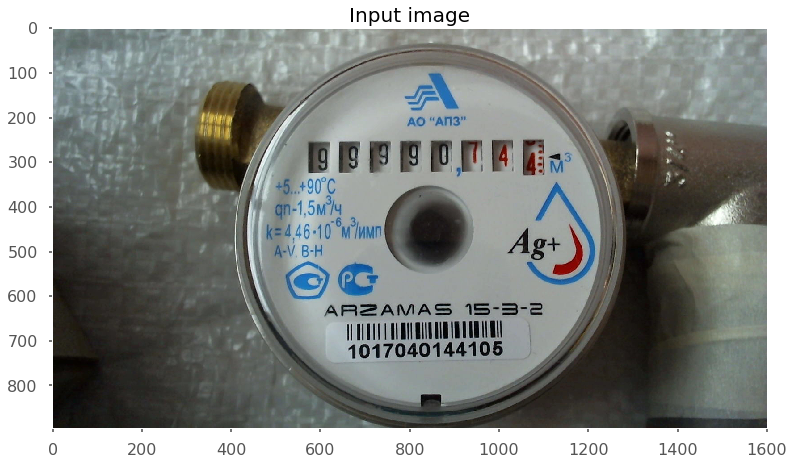

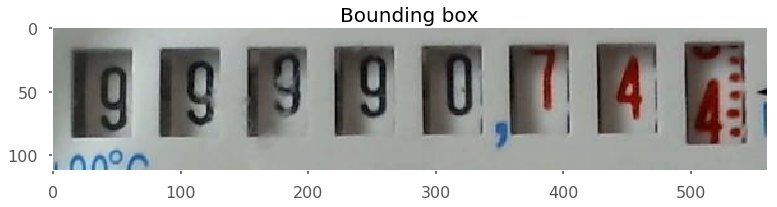

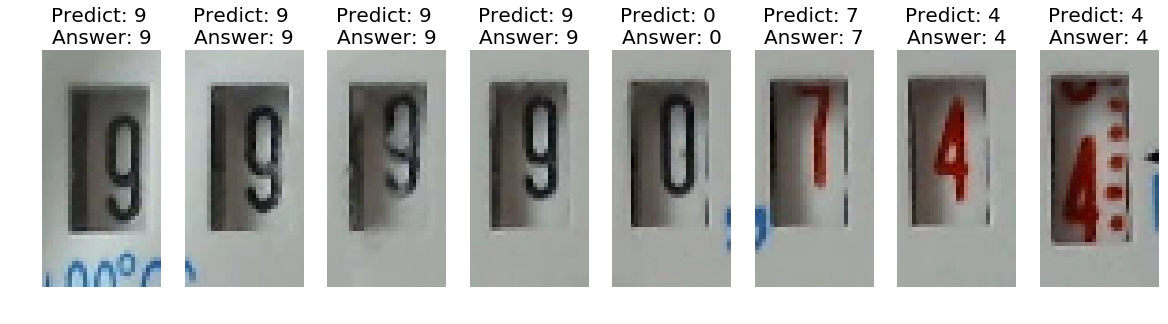

In [12]:
batch_test = predict_ppl.next_batch(1, n_epochs=None, shuffle=True)

predict = predict_ppl.get_variable('prediction')[-1]
labels = batch_test.labels[-1]
sepcrop = batch_test.sepcrop[-1]
plt.title('Input image', fontsize=20)
plt.imshow(batch_test.images[-1])
plt.grid()
plt.show()

plt.title('Bounding box', fontsize=20)
plt.imshow(batch_test.cropped[-1])
plt.grid()

_, axis = plt.subplots(1, 8, figsize=(20, 10))
axis = axis.reshape(-1)
for i in range(8):
    axis[i].imshow(sepcrop[i])
    axis[i].set_title('Predict: {} \nAnswer: {}'.format(predict[i], labels[i]), fontsize=20)
    axis[i].grid()
    axis[i].axis('off')
plt.show()

Summing up in this example we learned:
* how to use meter batch
* categorize a number on water meter